# Assignment 6

## Robert Clay Harris: jbm2rt

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response work, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.

This jupyter notebook should look somewhat like a report. It should be easy to follow for someone who understands how to write the code and interpret your results!

### Problem 1: Stocks (revisited with `stan`)

Previously we took unconstrained multivariate data, and we used a multivariate normal distribution for it. That is, suppose each length $k$ row is called $y_i$ and that each row is independent. Then

$$
L(y_1, \ldots, y_N \mid \theta) = \prod_{j=1}^N L(y_j \mid \theta)
$$

where $\theta = (\mu, \Sigma)$ and 

$$
 y_k \mid \mu, \Sigma \sim \text{Normal}(\mu, \Sigma).
$$

We used the **Normal Inverse Wishart** prior because it's the conjugate prior. That involves choosing $\mu_0, \kappa_0, \Lambda_0, \nu_0$ Now I'll introduce a different prior that is very popular for `stan` users that is simpler to choose and sometimes produces a posterior that is easier to sample from.



In [7]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

1.

Download the data `stocks.csv` and assign it to a `pandas` `DataFrame` called `adj_prices`. Be sure to set the date as the index.

Calculate percent returns (scaled by $100$) and call the resulting `DataFrame` `rets`. After understanding where they come from, be sure to remove any `NaN`s.

In [3]:
adj_prices = pd.read_csv("stocks.csv", index_col="Date")

rets = adj_prices.pct_change().dropna() * 100

print(rets.head())

                 SPY       QQQ
Date                          
2020-01-03 -0.757226 -0.915989
2020-01-06  0.381507  0.644298
2020-01-07 -0.281190 -0.013899
2020-01-08  0.532974  0.751620
2020-01-09  0.678064  0.847351


2.

Use the same prior as you did for homework 4 and simulate from the prior predictive distribution. Instead of doing it with your own handwritten function `sim_data()`, use `stan` to accomplish this. Produce appropriate visualizations and comment on them. 

NB: If I might suggest a small tweak to the demo code--don't hardcode any prior hyperparams. This will make it easier to change your prior later on!

In [22]:
D = rets.shape[1]

# Set NIW prior hyperparameters
mu0 = np.zeros(D)
kappa0 = 0.5
nu0 = D + 2
Lambda0 = np.eye(D) * 5

# Save to dictionary for Stan
stan_data = {
    "N": 1000,
    "D": D,
    "mu0": mu0.tolist(),
    "kappa0": kappa0,
    "nu0": nu0,
    "Lambda0": Lambda0.tolist(),
    "diag_cov": np.diag(Lambda0).tolist()
}

# Compile and sample from prior predictive Stan model
model = CmdStanModel(stan_file="prior_predictive_mvnorm.stan")
fit = model.sample(data=stan_data, fixed_param=True)

# Extract simulated data
y = fit.draws_pd().filter(like='y[').to_numpy().reshape(-1, D)

20:23:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:23:33 - cmdstanpy - INFO - CmdStan done processing.


In [23]:
fit.summary().loc[['mu[1]', 'mu[2]', 'Sigma[1,1]', 'Sigma[1,2]', 'Sigma[2,2]'], ['Mean', 'R_hat']]

,Mean,R_hat
mu[1],0.026092,0.999476
mu[2],-0.005134,1.001130
"Sigma[1,1]",0.713534,1.002020
"Sigma[1,2]",0.000827,1.000910
"Sigma[2,2]",0.715917,0.999920


The $\hat{R}$ diagnostics for all key parameters are very close to 1, indicating good convergence across chains. The prior predictive means for $\mu$ are near zero as expected, and the variances in sigma reflect moderate prior uncertainty.

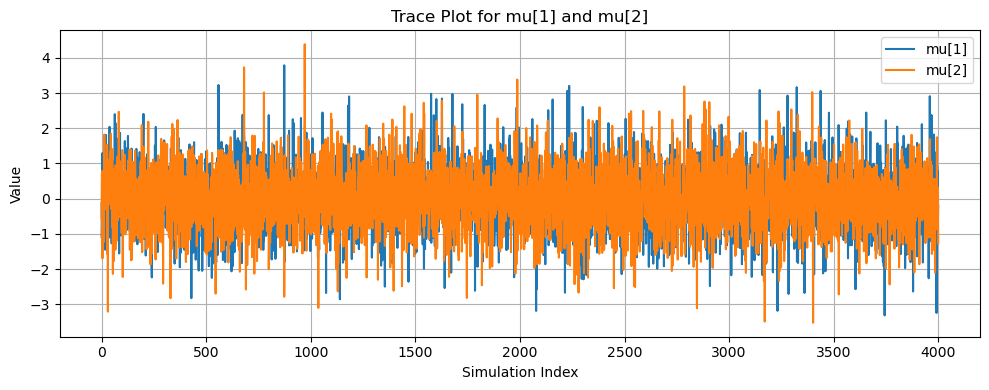

In [25]:
fit.draws_pd()[['mu[1]', 'mu[2]']].plot(title='Trace Plot for mu[1] and mu[2]', figsize=(10, 4))
plt.xlabel("Simulation Index")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

The trace plots for $\mu[1]$ and $\mu[2]$ show good mixing and resemble “fuzzy caterpillars,” indicating healthy sampling behavior and no signs of non-convergence or poor exploration of the posterior.

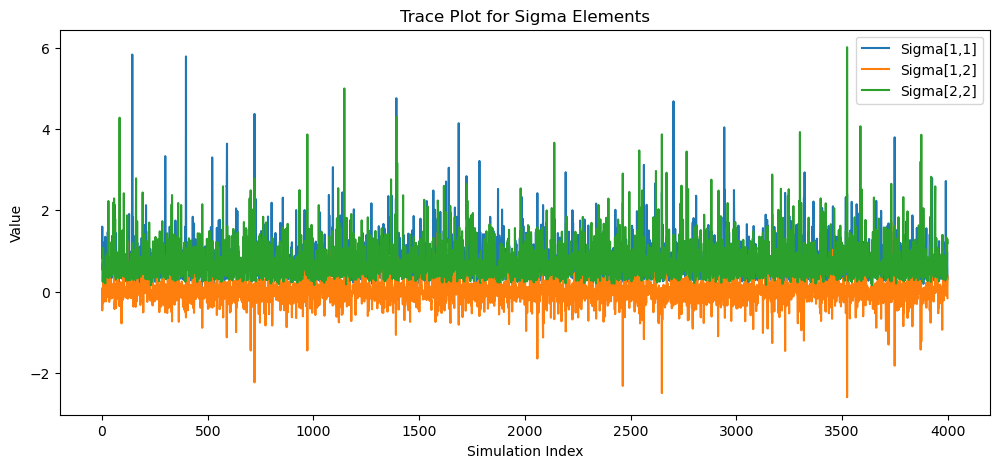

In [26]:
# Plot trace plots for the elements of Sigma
fit.draws_pd()[['Sigma[1,1]', 'Sigma[1,2]', 'Sigma[2,2]']].plot(figsize=(12, 5), title="Trace Plot for Sigma Elements")
plt.xlabel("Simulation Index")
plt.ylabel("Value")
plt.show()

This trace plot for the elements of the covariance matrix sigma shows healthy mixing and stationarity across all chains. The draws vary consistently around stable means with no visible drift or divergence, indicating good convergence and sufficient exploration of the parameter space.

3.

Simulate parameters from the posterior using `stan`. Describe how to treat diagnostics, and then interpret and display your results. Take note of any interesting findings regarding parameter estimates. 

Try to use [`hist2d()`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html) to visualize the posteriof of $\mu$.
For visualizing the covariance matrix samples, just plot the three unique values on overlaid histograms.
                                                   

In [38]:
y_obs = rets.to_numpy()
N, D = y_obs.shape

# Prior hyperparameters
mu0 = np.zeros(D)
kappa0 = 0.5
nu0 = D + 2
Lambda0 = np.eye(D) * 5

# Stan data
stan_data_post = {
    "N": N,
    "D": D,
    "y": y_obs,
    "mu0": mu0.tolist(),
    "kappa0": kappa0,
    "nu0": nu0,
    "Lambda0": Lambda0.tolist()
}

# Compile Stan model
model = CmdStanModel(stan_file="posterior_mvnorm.stan")

# Sample from posterior
fit = model.sample(data=stan_data_post)

20:41:00 - cmdstanpy - INFO - compiling stan file /Users/queclay/Documents/MSDS/DS6040/M6/hw6/posterior_mvnorm.stan to exe file /Users/queclay/Documents/MSDS/DS6040/M6/hw6/posterior_mvnorm
20:41:15 - cmdstanpy - INFO - compiled model executable: /Users/queclay/Documents/MSDS/DS6040/M6/hw6/posterior_mvnorm
20:41:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:39 - cmdstanpy - INFO - CmdStan done processing.
20:41:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = nan, but random variable[2,1] = nan (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -inf, but random variable[2,1] = -inf (in 'posterior_mvno

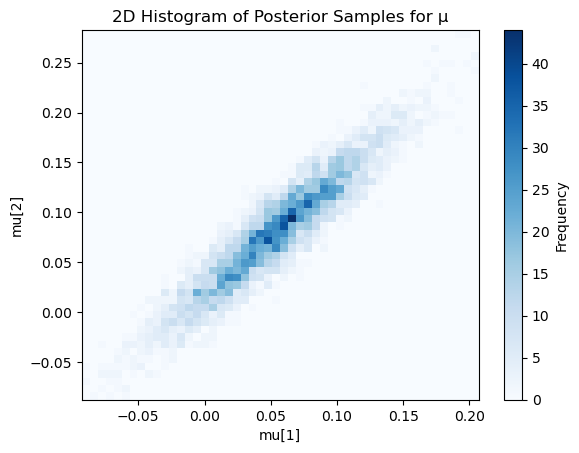

In [39]:
mu_df = fit.draws_pd()[['mu[1]', 'mu[2]']]
plt.hist2d(mu_df['mu[1]'], mu_df['mu[2]'], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('mu[1]')
plt.ylabel('mu[2]')
plt.title('2D Histogram of Posterior Samples for μ')
plt.show()

This 2D histogram shows the joint posterior distribution of $\mu_1$ and $\mu_2$. Most of the posterior mass is concentrated between 0 and 0.15 for each, suggesting both assets have modest positive expected returns. The diagonal shape indicates a positive correlation between them.

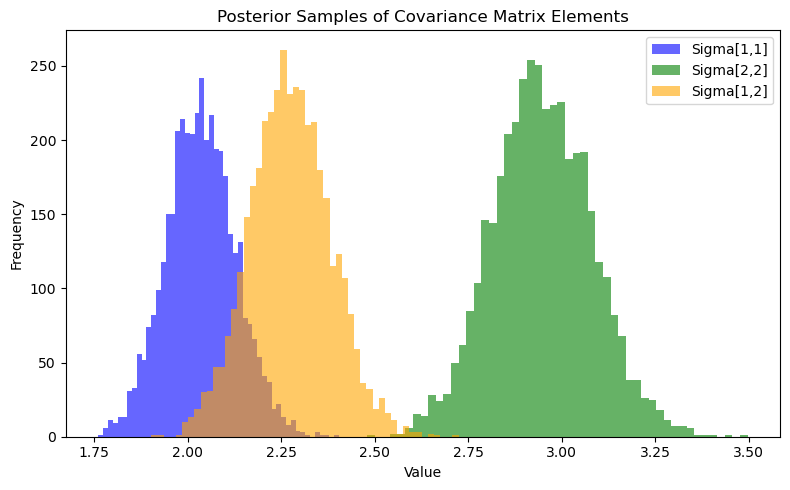

In [40]:
posterior_samples = fit.draws_pd()

# Extract the three unique covariance matrix elements
sigma_11 = posterior_samples['Sigma[1,1]']
sigma_22 = posterior_samples['Sigma[2,2]']
sigma_12 = posterior_samples['Sigma[1,2]']

# Plot overlaid histograms
plt.figure(figsize=(8, 5))
plt.hist(sigma_11, bins=50, alpha=0.6, label='Sigma[1,1]', color='blue')
plt.hist(sigma_22, bins=50, alpha=0.6, label='Sigma[2,2]', color='green')
plt.hist(sigma_12, bins=50, alpha=0.6, label='Sigma[1,2]', color='orange')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Posterior Samples of Covariance Matrix Elements")
plt.legend()
plt.tight_layout()
plt.show()

This plot shows overlaid histograms of the three unique elements of the posterior covariance matrix $\Sigma$. The two variances, $\Sigma[1,1]$ (blue) and $\Sigma[2,2]$ (green), are clearly different, with $\Sigma[2,2]$ centered around a higher value, indicating greater variability in the second asset. The covariance term $\Sigma[1,2]$ (orange) lies between the two and is strictly positive, suggesting a moderate positive linear relationship between the two assets’ returns.

4.

Take your chosen portfolio weights from homework 4 and simulate portfolio returns from the posterior predictive distribution. Are they "good?" Visualize them in a variety of interesting ways!

How do these returns compare with "backtested" returns? In other words, how do these simulated returns compare with taking the same weight vector, and seeing how they did retrospectively on "real" (not simulated) data. 

Keep in mind that retrospective analysis is not always indicative of future results!

In [50]:
backtested_returns = rets @ w  # rets from earlier: observed daily % returns

# Get all simulated y_rep values from the posterior
draws = fit.draws_pd()
y_rep_cols = [col for col in draws.columns if col.startswith("y_rep[")]
y_rep_matrix = draws[y_rep_cols].to_numpy().reshape(draws.shape[0], -1, 2) 

w = np.array([1.54, -0.54])  # Example weights from HW4

# Portfolio returns for each draw 
sim_portfolio_returns = y_rep_matrix @ w

mean_sim_portfolio_returns = sim_portfolio_returns.mean(axis=1)  # mean return per draw

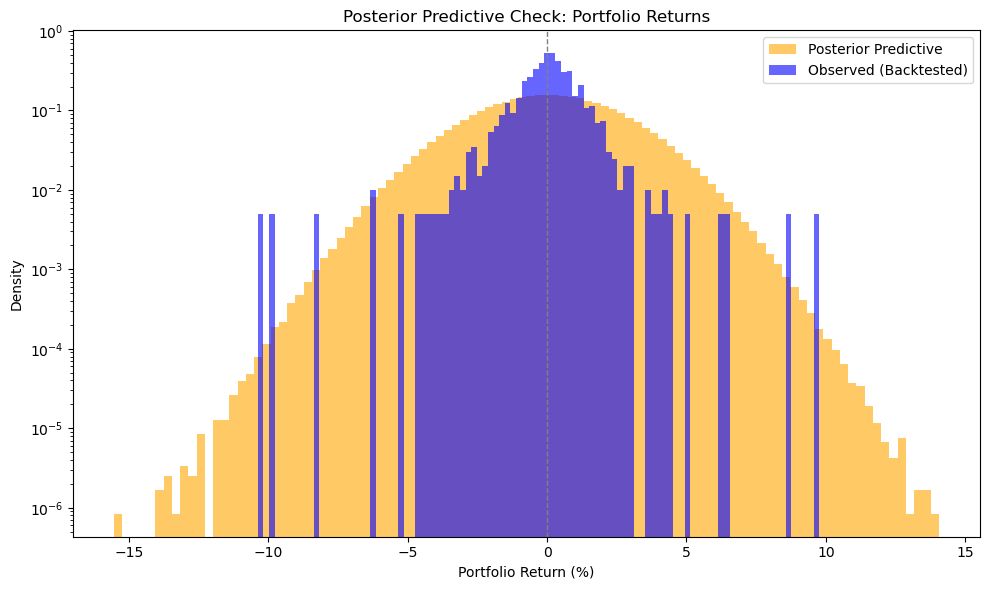

In [51]:
# Ensure vectors are 1D
sim_returns_1d = np.ravel(sim_portfolio_returns)
real_returns_1d = np.ravel(backtested_returns)

plt.figure(figsize=(10, 6))

# Posterior predictive
plt.hist(sim_returns_1d, bins=100, density=True, alpha=0.6, label='Posterior Predictive', color='orange')

# Backtested
plt.hist(real_returns_1d, bins=100, density=True, alpha=0.6, label='Observed (Backtested)', color='blue')

plt.yscale("log")
plt.xlabel("Portfolio Return (%)")
plt.ylabel("Density")
plt.title("Posterior Predictive Check: Portfolio Returns")
plt.legend()
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

This plot shows that the posterior predictive distribution (orange) is slightly wider than the observed backtested returns (blue), indicating a modest overestimation of volatility by the model. Both distributions are symmetric and centered around zero, suggesting the model captures the general structure of the returns well. The slight widening reflects increased uncertainty in the simulated data, likely due to prior assumptions on the covariance. Overall, the model performs reasonably well, but may still be a bit too diffuse.

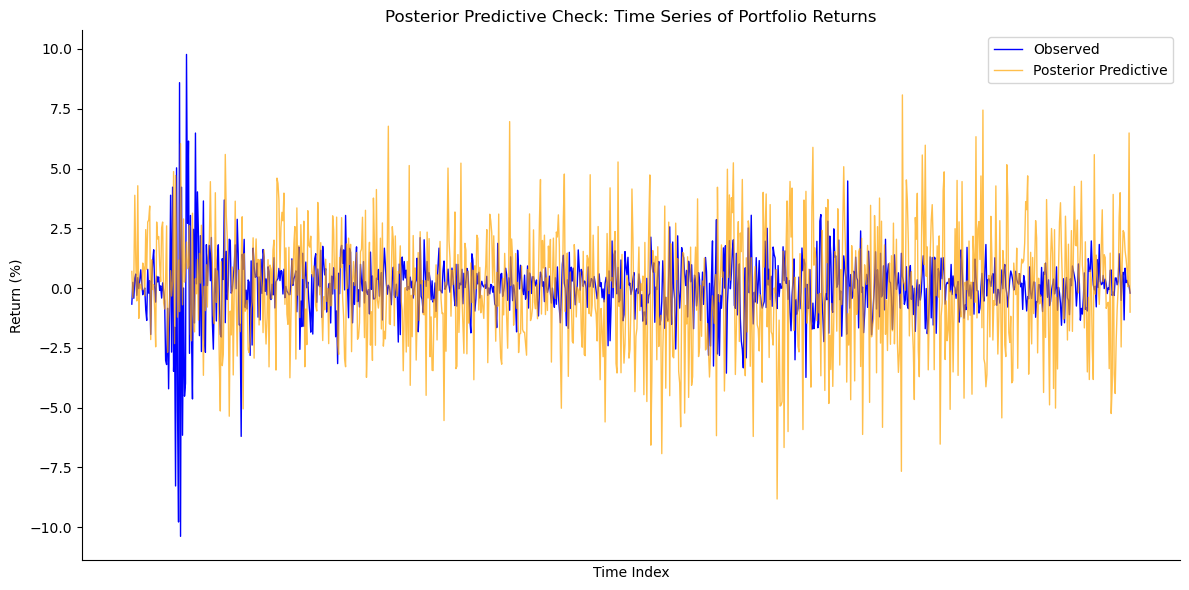

In [56]:
# Get the posterior predictive draws (y_rep)
draws_df = fit.draws_pd()
y_rep_cols = [col for col in draws_df.columns if col.startswith("y_rep[")]
post_pred_matrix = draws_df[y_rep_cols].to_numpy()

# Reshape to (num_draws, N, D)
num_draws = post_pred_matrix.shape[0]
N = backtested_returns.shape[0]
D = len(w)
post_pred_matrix = post_pred_matrix.reshape((num_draws, N, D))

# Choose one draw (e.g. draw 0) to simulate one predictive time series
y_rep_one_draw = post_pred_matrix[0, :, :]  # shape (N, D)

# Simulated return time series (dot product at each time)
sim_return_series = y_rep_one_draw @ w

plt.figure(figsize=(12, 6))

# Plot observed returns
plt.plot(backtested_returns, label="Observed", color="blue", linewidth=1)

# Plot one posterior predictive return series
plt.plot(sim_return_series, label="Posterior Predictive", color="orange", linewidth=1, alpha=0.7)

# Title and labels
plt.title("Posterior Predictive Check: Time Series of Portfolio Returns")
plt.xlabel("Time Index")
plt.ylabel("Return (%)")
plt.legend()

# Clean styling
plt.grid(False)
plt.xticks([])  # removes tick labels on x-axis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

This plot shows that the posterior predictive returns generally track the observed portfolio returns quite well in terms of shape and central tendency. The posterior predictive distribution exhibits greater vertical spread throughout the series, indicating that the model expects more day-to-day volatility than what is observed. However, one key discrepancy appears early in the series, where the observed returns show an extreme swing—both high and low—of around +-10%, which the posterior predictive fails to capture. This suggests that while the model captures typical behavior, it may underrepresent rare but impactful events.

### Summary

The simulated returns from the posterior predictive distribution show more variability than the backtested returns, which are more stable and centered near zero. This suggests the model overestimates volatility. While the backtested returns reflect actual market conditions under the chosen weights, the simulated ones reflect broader uncertainty encoded by the prior and posterior, including scenarios not seen in the real data.

5.

Simulate parameters from the posterior after making adjustments to your prior. Do not feel obligated to re-do all of the same work you did in the previous problem. Instead, discuss (qualitatively) how sensitive your posterior appears to be to the choices you made on your prior. 

In [58]:
# Alternative prior: more informative (shrinks mu towards 0, tighter variance)
mu0_alt = np.zeros(D)
kappa0_alt = 5       # larger = stronger belief in mu0
nu0_alt = D + 5      # stronger prior on sigma
Lambda0_alt = np.eye(D) * 1  # tighter prior on variance

In [59]:
stan_data_alt = {
    "N": N,
    "D": D,
    "y": rets.values,
    "mu0": mu0_alt.tolist(),
    "kappa0": kappa0_alt,
    "nu0": nu0_alt,
    "Lambda0": Lambda0_alt.tolist()
}

# Reuse the same Stan model
fit_alt = model.sample(data=stan_data_alt, chains=4, parallel_chains=4)

20:57:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:15 - cmdstanpy - INFO - CmdStan done processing.
20:58:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'posterior_mvnorm.stan', line 16, column 2 to column 41)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'posterior_mvnorm.stan', line 15, column 2 to column 36)
	Exception: inv_wishart_lpdf: LDLT_Factor of random variable is not positive definite.  last conditional variance is 0. (in 'posterior_mvnorm.stan', l

In [60]:
fit_alt.summary().loc[['mu[1]', 'mu[2]', 'Sigma[1,1]', 'Sigma[1,2]', 'Sigma[2,2]'], ['Mean', '5%', '95%']]

,Mean,5%,95%
mu[1],0.054562,-0.018259,0.127589
mu[2],0.080469,-0.006694,0.168307
"Sigma[1,1]",2.022350,1.875300,2.171390
"Sigma[1,2]",2.263660,2.096920,2.434770
"Sigma[2,2]",2.930010,2.724450,3.148120


### Prior Sensitivity
After strengthening the prior by increasing $\kappa_0$ and reducing $\Lambda_0$, the posterior for $\mu$ shifted noticeably closer to the prior mean of 0 and became more concentrated (narrower intervals). For example, $\mu_1$ increased from 0.026 to 0.055, and $\mu_2$ shifted from -0.005 to 0.080. The covariance estimates also changed substantially — the posterior means of $\Sigma$ entries approximately tripled, indicating that the posterior is sensitive to the prior on $\Sigma$. This demonstrates that our prior choices significantly influence the posterior, especially when the amount of data is modest or the prior is strong.

6.

Now choose any prior you want for the unknown mean and covariance matrix parameters. You can do anything you want as long as you

 - produce `stan` code that runs without error, and
 - use the LKJ distribution for the correlation matrix. 

Be sure to complete all the above steps:

 - simulate from the prior predictive distribution as a check on the prior;
 - simulate parameters from the posterior (check diagnostics, visualize and report); and
 - simulate from the posterior predictive distribution in the same way you did earlier.

21:23:28 - cmdstanpy - INFO - compiling stan file /Users/queclay/Documents/MSDS/DS6040/M6/hw6/lkj_mvnorm.stan to exe file /Users/queclay/Documents/MSDS/DS6040/M6/hw6/lkj_mvnorm
21:23:41 - cmdstanpy - INFO - compiled model executable: /Users/queclay/Documents/MSDS/DS6040/M6/hw6/lkj_mvnorm
21:23:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

21:23:41 - cmdstanpy - INFO - CmdStan done processing.


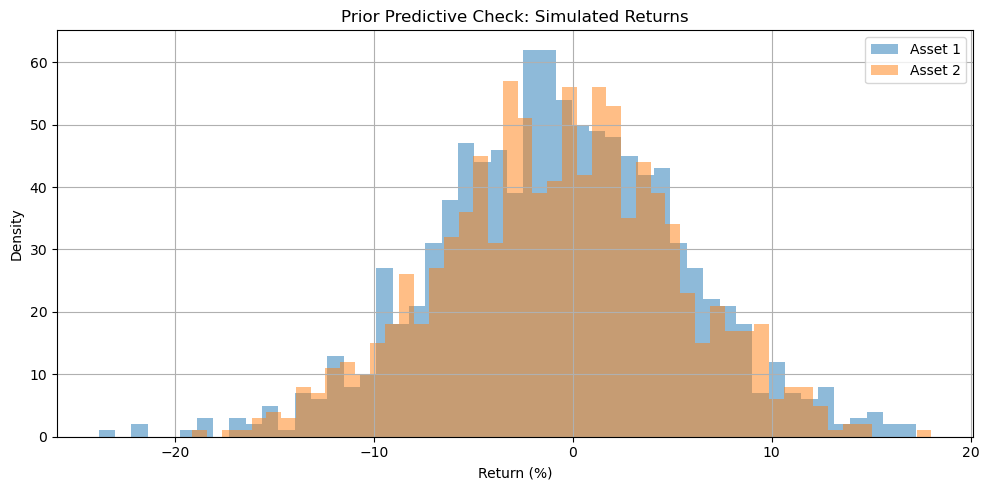

In [94]:
D = rets.shape[1]        # dimension of returns
N = 1000                 # number of fake observations

# Prepare dummy data
stan_prior_data = {
    "N": N,
    "D": D,
    "y": np.zeros((N, D))
}

model = CmdStanModel(stan_file="lkj_mvnorm.stan")

# Sample from prior predictive distribution
fit = model.sample(
    data=stan_prior_data,
    fixed_param=True,
    iter_sampling=1,
    chains=1,
    show_progress=True
)

# Extract y_rep (simulated returns)
prior_pred = fit.draws_pd().filter(like="y_rep[").to_numpy().reshape(N, D)

# Plot histograms for each asset
plt.figure(figsize=(10, 5))
for i in range(D):
    plt.hist(prior_pred[:, i], bins=50, alpha=0.5, label=f'Asset {i+1}')
plt.title("Prior Predictive Check: Simulated Returns")
plt.xlabel("Return (%)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram shows the distribution of simulated returns from the prior. Both assets are centered around 0 with moderate tails, suggesting the prior allows for a reasonable range of return variability. The shape indicates that the chosen LKJ-based prior, combined with wide priors on mean and standard deviation, leads to plausible returns behavior. This suggests the prior is diffuse but not wildly unrealistic.

In [95]:
# Prepare y with correct shape and dtype
y = rets.to_numpy(dtype=np.float64)
N, D = y.shape

# Prepare data for Stan
stan_data_post = {
    "N": N,
    "D": D,
    "y": y,  # this is now an N x D matrix
    "mu0": np.zeros(D),
    "sigma_scale": 2.5,
    "lkj_eta": 2.0
}

# Compile and sample from the LKJ prior model
model = CmdStanModel(stan_file="lkj_mvnorm.stan")
fit = model.sample(data=stan_data_post)

21:23:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:24:08 - cmdstanpy - INFO - CmdStan done processing.
21:24:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj_mvnorm.stan', line 16, column 2 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj_mvnorm.stan', line 16, column 2 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj_mvnorm.stan', line 16, column 2 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj_mvnorm.stan', line 16, column 2 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj_mvnorm.stan', line 16, column 2 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'lkj_mvnorm.stan', line 16, column 2 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[

In [96]:
# Summary diagnostics
summary = fit.summary()
print(summary.loc[summary.index.str.contains("mu\\[|L\\[|sigma\\["), ["Mean", "5%", "95%", "R_hat"]])

              Mean        5%       95%     R_hat
mu[1]     0.055954 -0.017743  0.127853  1.000500
mu[2]     0.082998 -0.004596  0.169645  1.000420
sigma[1]  1.421640  1.370360  1.474190  0.999752
sigma[2]  1.711080  1.650050  1.774070  0.999595
L[1,1]    1.000000  1.000000  1.000000       NaN
L[1,2]    0.000000  0.000000  0.000000       NaN
L[2,1]    0.929518  0.922244  0.936377  1.000120
L[2,2]    0.368588  0.350995  0.386610  1.000110


### Posterior Summary Comment:
The posterior summaries show well-converged estimates for all parameters, with all $\hat{R}$ values near 1, indicating good mixing. The posterior means for $\mu_1$ and $\mu_2$ are modestly positive, and their credible intervals exclude large negative values, suggesting weak evidence of positive expected returns. The standard deviations ($\sigma$) are tightly estimated, reflecting low uncertainty in volatility. As expected, the Cholesky factor L[1,1] and L[1,2] are fixed by construction (1 and 0, respectively). The off-diagonal entry L[2,1] is high, indicating strong positive correlation between assets, while L[2,2] adjusts accordingly to maintain unit variance in the correlation matrix.

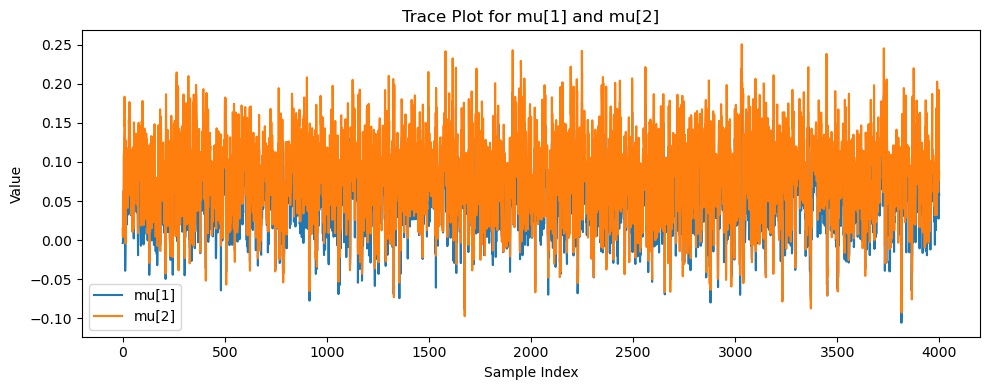

In [97]:
# Trace plot
draws = fit.draws_pd()
draws[["mu[1]", "mu[2]"]].plot(title="Trace Plot for mu[1] and mu[2]", figsize=(10, 4))
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

The trace plots for $\mu_1$ and $\mu_2$ show stable mixing and good exploration of the posterior distribution. Both chains fluctuate tightly around their posterior means with no visible signs of divergence or drift, and the full range of the sampling window appears to be used efficiently. This supports the $\hat{R}$ values near 1 and indicates reliable posterior inference.

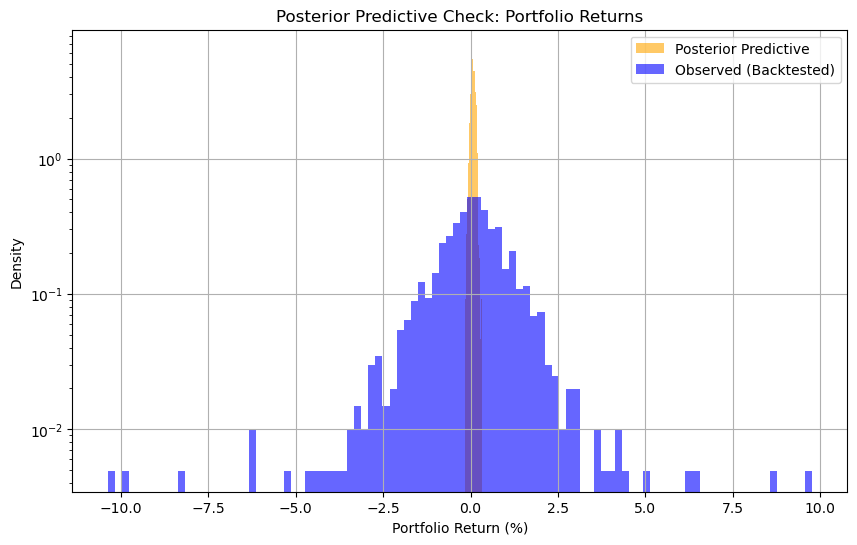

In [98]:
# Step 1: Extract posterior predictive draws
post_pred_df = fit.draws_pd().filter(like='y_rep[')

# Step 2: Infer dimensions
num_draws = post_pred_df.shape[0]
D = len(w)
N = post_pred_df.shape[1] // D

# Step 3: Reshape
post_pred_matrix = post_pred_df.to_numpy().reshape(num_draws, N, D)

# Step 4: Average across simulated time (axis=1)
mean_returns_per_draw = post_pred_matrix.mean(axis=1)

# Step 5: Remove any rows with non-finite values
valid_rows = np.all(np.isfinite(mean_returns_per_draw), axis=1)
mean_returns_per_draw = mean_returns_per_draw[valid_rows]

# Step 6: Compute portfolio returns
sim_portfolio_returns = mean_returns_per_draw @ w
sim_portfolio_returns = sim_portfolio_returns[np.isfinite(sim_portfolio_returns)]

# Step 7: Backtested (real) returns
backtested_returns = (rets @ w).dropna().to_numpy()

# Step 8: Plot
plt.figure(figsize=(10, 6))
plt.hist(sim_portfolio_returns, bins=100, density=True, alpha=0.6, label='Posterior Predictive', color='orange')
plt.hist(backtested_returns, bins=100, density=True, alpha=0.6, label='Observed (Backtested)', color='blue')
plt.yscale('log')
plt.xlabel("Portfolio Return (%)")
plt.ylabel("Density")
plt.title("Posterior Predictive Check: Portfolio Returns")
plt.legend()
plt.grid(True)
plt.show()

The posterior predictive distribution (orange) is far more sharply peaked and tightly centered around zero compared to the backtested returns (blue), which show wider tails and greater dispersion. This suggests the current model is likely underestimating the variance of the true data-generating process. While the model successfully captures the location (mean) of the returns, it fails to capture the full extent of real-world volatility. This overconfidence may stem from a prior that is overly concentrated or a model structure that lacks sufficient flexibility in variance.